In [11]:
import os
import re
import torch.nn as nn
from torchvision import models
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torchvision import datasets, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./MNIST_Dataset", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./MNIST_Dataset", train=False, transform=transform, download=True)


In [14]:
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset)-train_size

In [15]:
train_subset,val_subset = random_split(train_dataset,[train_size,val_size])
train_loader = DataLoader(train_subset, batch_size = 1024,shuffle= True)
val_loader = DataLoader(val_subset,batch_size=1024)
test_loader = DataLoader(test_dataset,batch_size=len(test_dataset))

In [16]:
X_test,Y_test = next(iter(test_loader))
X_test.shape

torch.Size([10000, 1, 28, 28])

In [17]:
x_batch_train, y_batch_train = next(iter(train_loader))
print(x_batch_train.shape, y_batch_train.shape)


torch.Size([1024, 1, 28, 28]) torch.Size([1024])


In [18]:
class MLP_MNIST_Experiment(nn.Module):
    def __init__(self,channels,input_dim,fc1_size=30,fc2_size=20):
        super().__init__()
        self.arch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels*input_dim*input_dim,fc1_size),
            nn.ReLU(),
            nn.Linear(fc1_size,fc2_size),
            nn.ReLU(),
            nn.Linear(fc2_size,10),
        )
    
    def forward(self,x):
        return self.arch(x)




In [19]:
channels = x_batch_train.shape[1]
input_dim = x_batch_train.shape[2]
batch_size = 1024

In [20]:
model = MLP_MNIST_Experiment(channels,input_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr =1e-2,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [21]:
val_losses = []
train_losses = []

In [22]:
def evaluate():
    model.eval()
    total_val_loss = 0
    batch_count = 0

    with torch.no_grad(),torch.amp.autocast("cuda"):
        for x_batch_val,y_batch_val in val_loader:
            x_batch_val = x_batch_val.to(device)
            y_batch_val = y_batch_val.to(device)
            logits = model(x_batch_val)
            val_loss = criterion(logits,y_batch_val)
            total_val_loss +=val_loss.item()
            batch_count+=1
        
    return total_val_loss/batch_count
        
    


In [23]:
epochs = 20
batch_size = 1024
scaler = torch.amp.GradScaler()

model.train()

for epoch in range(epochs):
    for x_batch_train, y_batch_train in train_loader:
        x_batch_train = x_batch_train.to(device)
        y_batch_train = y_batch_train.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            logits = model(x_batch_train)
            loss = criterion(logits,y_batch_train)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    val_losses.append(evaluate())
    train_losses.append(loss.item())
    
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Validation Loss: {evaluate():.4f}")

Epoch 0, Train Loss: 0.3827, Validation Loss: 0.3168
Epoch 1, Train Loss: 0.2478, Validation Loss: 0.2385
Epoch 2, Train Loss: 0.1864, Validation Loss: 0.1990
Epoch 3, Train Loss: 0.1591, Validation Loss: 0.1830
Epoch 4, Train Loss: 0.1326, Validation Loss: 0.1651
Epoch 5, Train Loss: 0.1557, Validation Loss: 0.1536
Epoch 6, Train Loss: 0.1034, Validation Loss: 0.1474
Epoch 7, Train Loss: 0.1234, Validation Loss: 0.1512
Epoch 8, Train Loss: 0.1016, Validation Loss: 0.1433
Epoch 9, Train Loss: 0.1002, Validation Loss: 0.1410
Epoch 10, Train Loss: 0.1101, Validation Loss: 0.1548
Epoch 11, Train Loss: 0.1200, Validation Loss: 0.1581
Epoch 12, Train Loss: 0.1097, Validation Loss: 0.1386
Epoch 13, Train Loss: 0.0891, Validation Loss: 0.1417
Epoch 14, Train Loss: 0.0725, Validation Loss: 0.1434
Epoch 15, Train Loss: 0.0672, Validation Loss: 0.1489
Epoch 16, Train Loss: 0.0584, Validation Loss: 0.1474
Epoch 17, Train Loss: 0.0587, Validation Loss: 0.1544
Epoch 18, Train Loss: 0.0601, Validati

In [24]:
model.eval()

with torch.no_grad():
    X_test_device = X_test.to(device)
    logits = model(X_test_device)
    predictions = torch.argmax(logits,dim=1)

accuracy = accuracy_score(predictions.cpu(),Y_test)
f1 = f1_score(predictions.cpu(),Y_test,average="macro")
recall = recall_score(predictions.cpu(),Y_test,average="macro")
precision = precision_score(predictions.cpu(),Y_test,average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision}")


Accuracy: 0.9627
Recall: 0.9627
Precision: 0.9619845627715531


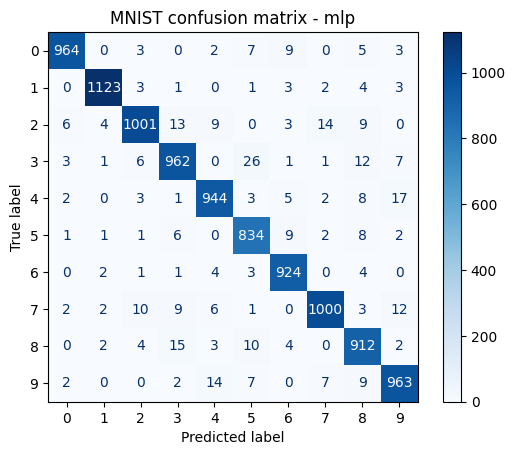

In [25]:
cm = confusion_matrix(predictions.cpu(),Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues', values_format= 'd')
plt.title("MNIST confusion matrix - mlp")
plt.show()

In [26]:
train_tensor = DataLoader(train_subset,batch_size=len(train_subset))
X_train,Y_train = next(iter(train_tensor))
X_train = X_train.view(X_train.shape[0],-1)
X_train.shape


torch.Size([48000, 784])

## Random Forest Classifier

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10)

rf.fit(X_train,Y_train)
predictions_train = rf.predict(X_train)


In [28]:
train_acc = accuracy_score(predictions_train,Y_train)
X_test = X_test.view(X_test.shape[0],-1)
predictions_test = rf.predict(X_test)
test_acc = accuracy_score(predictions_test,Y_test)
test_recall = recall_score(predictions_test,Y_test,average = "macro")
test_precision = precision_score(predictions_test,Y_test,average = "macro")
test_f1 = f1_score(predictions_test,Y_test,average = "macro")

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score {test_f1:.4f}")

Train Accuracy: 0.9672
Test Accuracy: 0.9487
Test Recall: 0.9488
Test Precision: 0.9483
Test F1 Score 0.9484


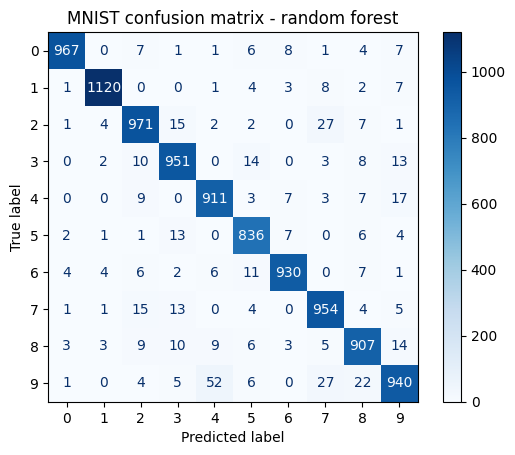

In [29]:
cm = confusion_matrix(predictions_test,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(cmap = "Blues",values_format='d')
plt.title("MNIST confusion matrix - random forest")
plt.show()

## Logistic Regression

In [30]:
log_reg = LogisticRegression(max_iter= 500, solver = 'lbfgs',n_jobs=-1)
X_train = X_train.view(X_train.shape[0],-1)
log_reg.fit(X_train,Y_train)
predictions_train = log_reg.predict(X_train)

In [31]:
X_test = X_test.view(X_test.shape[0],-1)
predictions_test = log_reg.predict(X_test)

In [32]:
train_acc = accuracy_score(predictions_train,Y_train)
test_acc = accuracy_score(predictions_test,Y_test)
test_recall = recall_score(predictions_test,Y_test,average='macro')
test_precision = precision_score(predictions_test,Y_test,average='macro')
test_f1 = f1_score(predictions_test,Y_test,average = 'macro')

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test F1 Score {test_f1:.4f}")

Train Accuracy: 0.9393
Test Accuracy: 0.9257
Test Recall: 0.9247
Test Precision: 0.9246
Test F1 Score 0.9246


MLP is the best, then the Random Forest then Logistic regression in terms of the metrics shown for all three

In [33]:
def get_embeddings(model,X):
    if isinstance(model,MLP_MNIST_Experiment):
        model.eval()
        with torch.no_grad():
            x = model.arch[0:4](X)
        return x
        

In [34]:
emb_trained = get_embeddings(model.cpu(),X_train).detach().cpu().numpy()
untrained_model = MLP_MNIST_Experiment(channels,input_dim)
emb_untrained = get_embeddings(untrained_model.cpu(),X_train).detach().cpu().numpy()

tsne_trained = TSNE(n_components=2,perplexity=30,random_state=42)
tsne_untrained = TSNE(n_components=2,perplexity=30,random_state=42)
emb_2d_trained = tsne_trained.fit_transform(emb_trained)
emb_2d_untrained = tsne_untrained.fit_transform(emb_untrained)


KeyboardInterrupt: 

In [ ]:
labels_np = Y_train.detach().cpu().numpy()

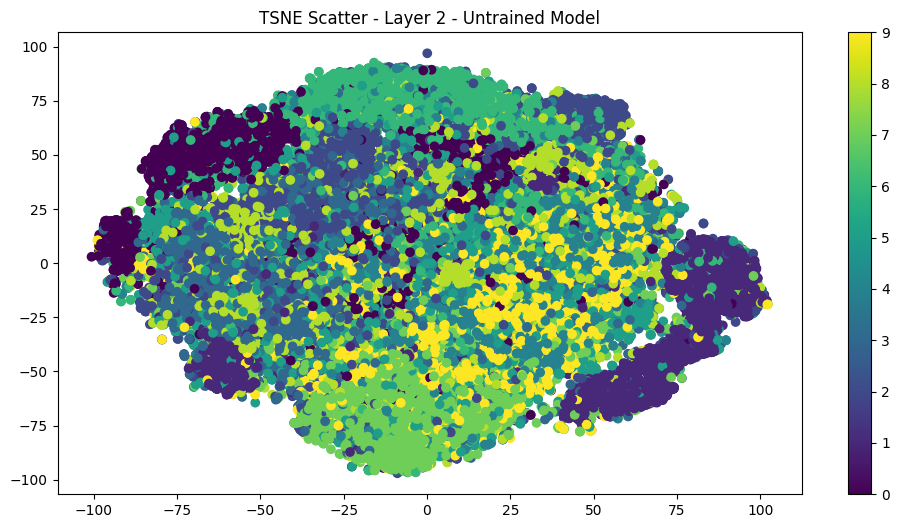

In [ ]:
plt.figure(figsize = (12,6))
scatter = plt.scatter(emb_2d_untrained[:,0],emb_2d_untrained[:,1],c = labels_np)
plt.colorbar(scatter)
plt.title("TSNE Scatter - Layer 2 - Untrained Model")
plt.show()

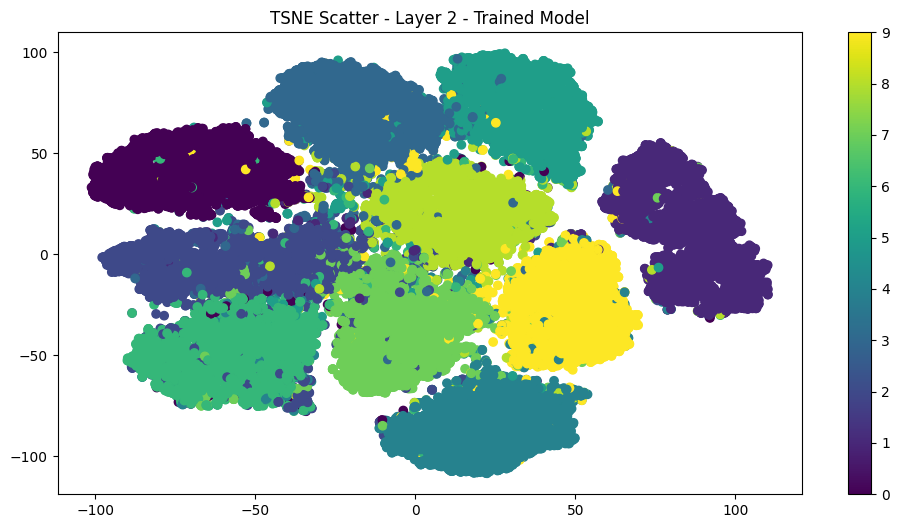

In [ ]:
plt.figure(figsize = (12,6))
scatter = plt.scatter(emb_2d_trained[:,0],emb_2d_trained[:,1],c = labels_np)
plt.colorbar(scatter)
plt.title("TSNE Scatter - Layer 2 - Trained Model")
plt.show()

In the trained model the t-SNE plot shows clear and distinct clusters for each digit indicating that the CNN has learned meaningful representations.
the untrained model shows overlapping and mixed clusters showing that it hasn’t learned to separate the classes yet.

In [ ]:
transform = transforms.ToTensor()
train_dataset_fashion = datasets.FashionMNIST(root = './Fashion_MNIST_Dataset',download = True, train = True, transform= transform)
test_dataset_fashion = datasets.FashionMNIST(root = './Fashion_MNIST_Dataset',download= True, train = False, transform=transform)

100%|██████████| 26.4M/26.4M [00:14<00:00, 1.84MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 147kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [ ]:
test_loader_fashion = DataLoader(test_dataset_fashion,batch_size=len(test_dataset_fashion))
X_test_fashion,Y_test_fashion = next(iter(test_loader_fashion))

X_test_fashion.shape

torch.Size([10000, 1, 28, 28])

In [ ]:
model.eval()
model.cuda()

with torch.no_grad():
    X_test_fashion_device = X_test_fashion.to(device)
    logits = model(X_test_fashion_device)
    predictions_test_fashion = torch.argmax(logits,dim=1)

accuracy_fashion = accuracy_score(predictions_test_fashion.cpu(),Y_test_fashion)
recall_fashion = recall_score(predictions_test_fashion.cpu(),Y_test_fashion,average='macro')
precision_fashion = precision_score(predictions_test_fashion.cpu(),Y_test_fashion,average='macro')
f1_fashion = f1_score(predictions_test_fashion.cpu(),Y_test_fashion,average="macro")

print(f"Accuracy on Fashion: {accuracy_fashion:.4f}")
print(f"Recall on Fashion: {recall_fashion:.4f}")
print(f"Precision on Fashion {precision_fashion:.4f}")
print(f"F1 Score on Fashion {f1_fashion:.4f}")


Accuracy on Fashion: 0.0904
Recall on Fashion: 0.1072
Precision on Fashion 0.0904
F1 Score on Fashion 0.0505


c:\Users\krish.HP.000\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
emb_fashion = get_embeddings(model.cpu(),X_test_fashion)
tsne_fashion = TSNE(n_components=2,random_state=42,perplexity=30)
emb_2d_fashion = tsne_fashion.fit_transform(emb_fashion)

In [ ]:
labels_np_fashion = Y_test_fashion.detach().cpu().numpy()
labels_np_fashion

array([9, 2, 1, ..., 8, 1, 5])

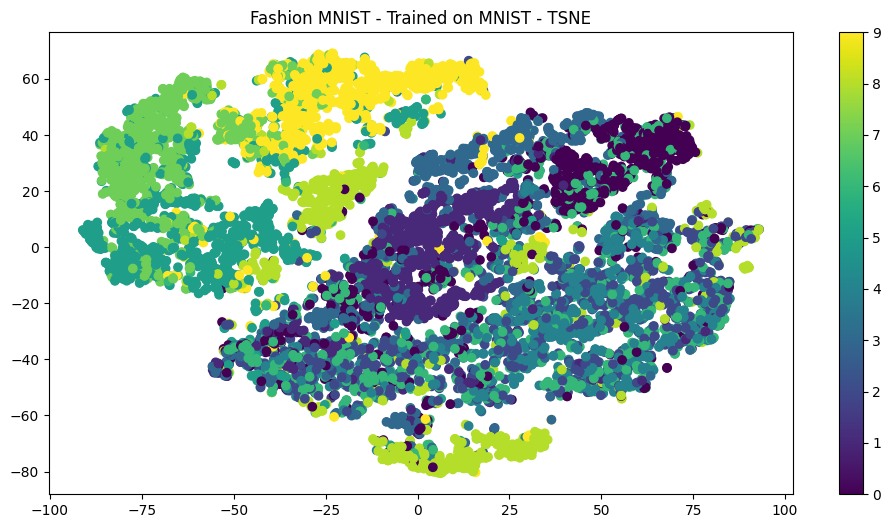

In [ ]:
plt.figure(figsize=(12,6))
scatter = plt.scatter(emb_2d_fashion[:,0],emb_2d_fashion[:,1],c = labels_np_fashion)

plt.colorbar(scatter)
plt.title("Fashion MNIST - Trained on MNIST - TSNE")
plt.show()

The MNIST-trained model shows clear and well-separated clusters meaning it learned distinct digit features.
the Fashion-MNIST embeddings are mixed and overlapping showing the model couldn’t generalize to new image types as it was never trained on it

## CNN MNIST Dataset

In [35]:
train_subset,val_subset = random_split(train_dataset,[train_size,val_size])
train_loader = DataLoader(train_subset, batch_size = 1024,shuffle= True)
val_loader = DataLoader(val_subset,batch_size=1024)
test_loader = DataLoader(test_dataset,batch_size=len(test_dataset))

In [36]:
class CNN_MNIST_Dataset(nn.Module):
    def __init__(self,channels,input_dim,fc1_size = 128,filter_count = 32,filter_size = 3):
        super().__init__()
        self.arch = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3,padding = 1),
                        nn.MaxPool2d(kernel_size = 2, stride = 2),
                        nn.Flatten(),
                        nn.Linear(filter_count*(input_dim//2)*(input_dim//2), fc1_size),
                        nn.ReLU(),
                        nn.Linear(fc1_size,10),               
                                  )
    
    def forward(self,x):
        return self.arch(x)

In [37]:
model = CNN_MNIST_Dataset(1,28).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-2,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [38]:
train_losses = []
val_losses = []

In [39]:
def evaluate():
    model.eval()
    batch_count = 0
    total_val_loss = 0

    with torch.no_grad():
        for x_batch_val,y_batch_val in val_loader:
            x_batch_val = x_batch_val.to(device)
            y_batch_val = y_batch_val.to(device)
            logits = model(x_batch_val)
            val_loss = criterion(logits,y_batch_val)
            total_val_loss+=val_loss.item()
            batch_count+=1
    
    return total_val_loss/batch_count

In [40]:
epochs = 20
batch_size = 1024

model.train()

scaler = torch.amp.GradScaler()

for epoch in range(epochs):
    for x_batch_train,y_batch_train in train_loader:
        x_batch_train = x_batch_train.to(device)
        y_batch_train = y_batch_train.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast("cuda"):
            logits = model(x_batch_train)
            loss = criterion(logits,y_batch_train)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    train_losses.append(loss.item())
    val_losses.append(evaluate())
    if epoch%1 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Validation Loss: {evaluate():.4f}")


Epoch 0, Train Loss: 0.3273, Validation Loss: 0.3197
Epoch 1, Train Loss: 0.1633, Validation Loss: 0.1581
Epoch 2, Train Loss: 0.1292, Validation Loss: 0.1438
Epoch 3, Train Loss: 0.0653, Validation Loss: 0.1074
Epoch 4, Train Loss: 0.0653, Validation Loss: 0.1056
Epoch 5, Train Loss: 0.0496, Validation Loss: 0.0808


KeyboardInterrupt: 

In [41]:
test_dataset = datasets.MNIST(root="./MNIST_Dataset", train=False, transform=transform, download=True)
test_dataset_cnn = DataLoader(test_dataset,batch_size=len(test_dataset))
X_test,Y_test = next(iter(test_dataset_cnn))
test_dataset_batch = DataLoader(test_dataset,batch_size=1024)



In [42]:
X_test_3_channels = X_test.repeat(1,3,1,1) # need to make then 3x224x224 to use pretained models
X_test_3_channels = torch.nn.functional.interpolate(X_test_3_channels,size=(224,224))
test_loader_resized = DataLoader(TensorDataset(X_test_3_channels,Y_test), batch_size=64, shuffle=False)


In [43]:
alexnet = models.alexnet(weights='IMAGENET1K_V1')
mobilenet = models.mobilenet_v2(weights= 'IMAGENET1K_V1')
alexnet.classifier[6] = nn.Linear(4096, 10)
alexnet = alexnet.to(device)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
mobilenet = mobilenet.to(device)


In [44]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [45]:
mobilenet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [46]:
import time

In [47]:
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(device), Y_test.to(device)
            outputs = model(X_test)
            preds = outputs.argmax(dim=1)
            y_true.extend(Y_test.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    end = time.time()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    inference_time = end - start
    return acc, f1, cm, inference_time


In [48]:
cnn_acc, cnn_f1, cnn_cm, cnn_time = evaluate_model(model, test_dataset_batch)
alex_acc, alex_f1, alex_cm, alex_time = evaluate_model(alexnet, test_loader_resized)
mob_acc, mob_f1, mob_cm, mob_time = evaluate_model(mobilenet, test_loader_resized)


In [49]:
print("CNN:", cnn_acc, cnn_f1,cnn_time)
print("AlexNet:", alex_acc, alex_f1, alex_time)
print("MobileNet:", mob_acc, mob_f1, mob_time)


CNN: 0.9757 0.9754779623117311 1.8169910907745361
AlexNet: 0.1094 0.051366921739933166 7.248943328857422
MobileNet: 0.1108 0.04564509797413461 29.404804468154907


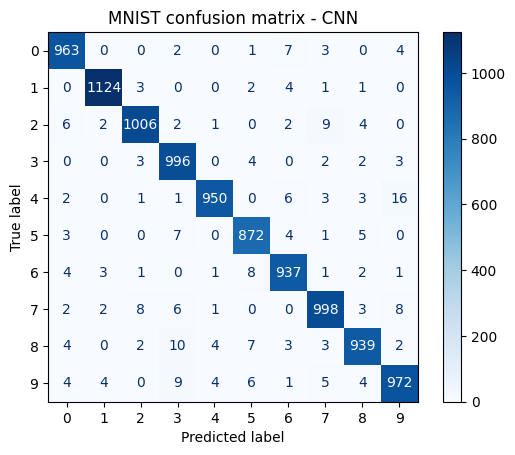

In [50]:

disp = ConfusionMatrixDisplay(confusion_matrix= cnn_cm)
disp.plot(cmap = "Blues",values_format='d')
plt.title("MNIST confusion matrix - CNN")
plt.show()

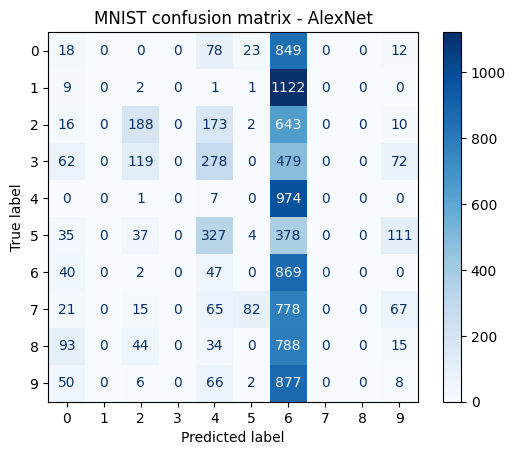

In [51]:

disp = ConfusionMatrixDisplay(confusion_matrix= alex_cm)
disp.plot(cmap = "Blues",values_format='d')
plt.title("MNIST confusion matrix - AlexNet")
plt.show()

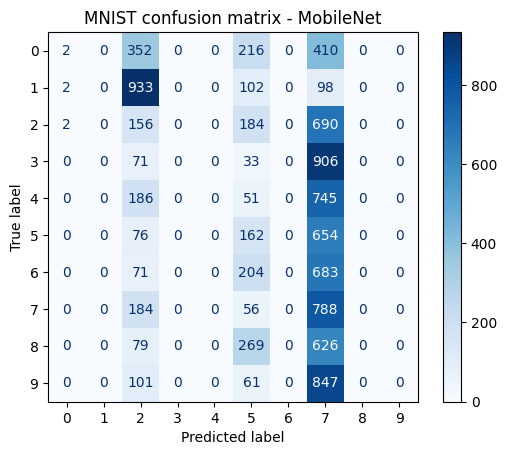

In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix= mob_cm)
disp.plot(cmap = "Blues",values_format='d')
plt.title("MNIST confusion matrix - MobileNet")
plt.show()